# Resistance plant gene prediction - Modeling
---

## Libraries

In [41]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Data preparation and scaling
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Modeling library
import tensorflow as tf
from tensorflow.keras.models import Model

# Modeling Layers
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import MultiHeadAttention, Embedding, GlobalAveragePooling1D, Dropout, LayerNormalization

# Speed up the model's training
from tensorflow.keras import mixed_precision


# Helper functions and Layers
import helper_functions as hf
from Positional_encoding import PositionalEncoding

## Data loading

In [2]:
proteins = pd.read_csv('Data/train.csv')

In [3]:
proteins.head()

,ID,Sequence,Label
0,0,MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...,0
1,4,MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...,0
2,5,MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...,0
3,6,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...,0
4,7,MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...,0


In [4]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14161 entries, 0 to 14160
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        14161 non-null  int64 
 1   Sequence  14161 non-null  object
 2   Label     14161 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 332.0+ KB


In [5]:
proteins[proteins.duplicated()].shape

(0, 3)

In [6]:
labels = pd.DataFrame(proteins['Label'])
labels.head()

,Label
0,0
1,0
2,0
3,0
4,0


In [7]:
sequences = proteins['Sequence']
sequences.head()

0    MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...
1    MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...
2    MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...
3    MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
4    MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...
Name: Sequence, dtype: object

## Data Preparation

### Tokenization

#### Char level

* Tokenize the sequences on char level

In [8]:
# Tokenize on char level
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(sequences)
sequences_1p = tokenizer1.texts_to_sequences(sequences)

# Padd the sequences to match all the length of the biggest
sequences_1p = pad_sequences(sequences_1p, padding='post')

In [9]:
sequences_1p

array([[17,  9,  2, ...,  0,  0,  0],
       [17,  3, 12, ...,  0,  0,  0],
       [17,  1,  6, ...,  0,  0,  0],
       ...,
       [17, 16, 13, ...,  0,  0,  0],
       [17,  3,  3, ...,  0,  0,  0],
       [17,  4, 10, ...,  0,  0,  0]], dtype=int32)

* Max sequence length

In [10]:
len(sequences_1p[0])

2028

#### 2 Amino Pairs

* Split the sequences per 2 aminos

In [11]:
dipeptide_sequences = hf.split_sequences(sequences, step=2)
pd.DataFrame(dipeptide_sequences[500])

,0
0,MA
1,SA
2,EG
3,GG
4,DK
...,...
113,GC
114,PV
115,MR
116,GA


In [12]:
sequences[500]

'MASAEGGGDKYRSFLHGDGEKKTVWRHGAPPNYDLVNKLFEEERTKEWAEGSVEEKVQRLLKTWEMEMVHKVRPEDQKSVNLKNYSASTNGLKPLTREEVMAMGGYNAFLATTLPPEHRIYDPEAESVESATSTFLTAFPRGFAIEVLDVYSSPSAPRIAFKFRHWGYMEGPFKGHPPHGGRVEFFGVCVFHVDEDTKVEKAEFFYERGNFLASFLTAPAASASASGCPVMRGAD'

In [13]:
tokenizer2 = Tokenizer(char_level=False)
tokenizer2.fit_on_texts(dipeptide_sequences)
sequences_2p = tokenizer2.texts_to_sequences(dipeptide_sequences)
sequences_2p = pad_sequences(sequences_2p, padding='post')

In [14]:
sequences_2p

array([[257,  54, 257, ...,   0,   0,   0],
       [132, 151,  55, ...,   0,   0,   0],
       [196,  19, 323, ...,   0,   0,   0],
       ...,
       [370, 182, 250, ...,   0,   0,   0],
       [132,  94, 252, ...,   0,   0,   0],
       [231, 318,  75, ...,   0,   0,   0]], dtype=int32)

* Max length

In [15]:
len(sequences_2p[0])

1014

#### 3 Amino Pairs

* Split the sequences per 3 aminos

In [16]:
tripeptide_sequences = hf.split_sequences(sequences, step=3)
pd.DataFrame(tripeptide_sequences[500])

,0
0,MAS
1,AEG
2,GGD
3,KYR
4,SFL
...,...
74,ASA
75,SGC
76,PVM
77,RGA


In [17]:
sequences[500]

'MASAEGGGDKYRSFLHGDGEKKTVWRHGAPPNYDLVNKLFEEERTKEWAEGSVEEKVQRLLKTWEMEMVHKVRPEDQKSVNLKNYSASTNGLKPLTREEVMAMGGYNAFLATTLPPEHRIYDPEAESVESATSTFLTAFPRGFAIEVLDVYSSPSAPRIAFKFRHWGYMEGPFKGHPPHGGRVEFFGVCVFHVDEDTKVEKAEFFYERGNFLASFLTAPAASASASGCPVMRGAD'

In [18]:
tokenizer3 = Tokenizer(char_level=False)
tokenizer3.fit_on_texts(tripeptide_sequences)
sequences_3p = tokenizer3.texts_to_sequences(tripeptide_sequences)
sequences_3p = pad_sequences(sequences_3p, padding='post')

In [19]:
sequences_3p

array([[2182, 5456, 5868, ...,    0,    0,    0],
       [1956,  766, 1178, ...,    0,    0,    0],
       [1946, 3717, 2905, ...,    0,    0,    0],
       ...,
       [6744, 5076, 3048, ...,    0,    0,    0],
       [ 233, 4150, 2315, ...,    0,    0,    0],
       [3401, 4360, 1172, ...,    0,    0,    0]], dtype=int32)

* Max length

In [20]:
len(sequences_3p[0])

676

### Train Test Split

#### Char level split

In [21]:
sequences_1p_train, sequences_1p_test, labels_1p_train, labels_1p_test = train_test_split(sequences_1p, labels, test_size=0.2, random_state=33)

In [22]:
print('Training shapes: ', sequences_1p_train.shape, labels_1p_train.shape)
print('Test shapes: ', sequences_1p_test.shape, labels_1p_test.shape)

Training shapes:  (11328, 2028) (11328, 1)
Test shapes:  (2833, 2028) (2833, 1)


In [23]:
scaler = StandardScaler()
sequences_1p_train_scaled = scaler.fit_transform(sequences_1p_train)
sequences_1p_test_scaled = scaler.fit_transform(sequences_1p_test)

In [24]:
# pd.DataFrame(sequences_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/train.csv')
# pd.DataFrame(sequences_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/test.csv')

# pd.DataFrame(labels_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_test.csv')

In [25]:
# pd.DataFrame(sequences_1p_train_scaled).to_csv('Data/Prepared_Data/1_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_1p_test_scaled).to_csv('Data/Prepared_Data/1_Amino_Pair/test_scaled.csv')

#### 2 Aminos split

In [26]:
sequences_2p_train, sequences_2p_test, labels_2p_train, labels_2p_test = train_test_split(sequences_2p, labels, test_size=0.2, random_state=33)

In [27]:
print('Training shapes: ', sequences_2p_train.shape, labels_2p_train.shape)
print('Test shapes: ', sequences_2p_test.shape, labels_2p_test.shape)

Training shapes:  (11328, 1014) (11328, 1)
Test shapes:  (2833, 1014) (2833, 1)


In [28]:
sequences_2p_train_scaled = scaler.fit_transform(sequences_2p_train)
sequences_2p_test_scaled = scaler.fit_transform(sequences_2p_test)

In [29]:
# pd.DataFrame(sequences_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/train.csv')
# pd.DataFrame(sequences_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/test.csv')

# pd.DataFrame(labels_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_test.csv')

In [30]:
# pd.DataFrame(sequences_2p_train_scaled).to_csv('Data/Prepared_Data/2_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_2p_test_scaled).to_csv('Data/Prepared_Data/2_Amino_Pair/test_scaled.csv')

#### 3 Aminos split

In [31]:
sequences_3p_train, sequences_3p_test, labels_3p_train, labels_3p_test = train_test_split(sequences_3p, labels, test_size=0.2, random_state=33)

In [32]:
print('Training shapes: ', sequences_3p_train.shape, labels_3p_train.shape)
print('Test shapes: ', sequences_3p_test.shape, labels_3p_test.shape)

Training shapes:  (11328, 676) (11328, 1)
Test shapes:  (2833, 676) (2833, 1)


In [33]:
sequences_3p_train_scaled = scaler.fit_transform(sequences_3p_train)
sequences_3p_test_scaled = scaler.fit_transform(sequences_3p_test)

In [34]:
# pd.DataFrame(sequences_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/train.csv')
# pd.DataFrame(sequences_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/test.csv')

# pd.DataFrame(labels_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_test.csv')

In [35]:
# pd.DataFrame(sequences_3p_train_scaled).to_csv('Data/Prepared_Data/3_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_3p_test_scaled).to_csv('Data/Prepared_Data/3_Amino_Pair/test_scaled.csv')

## Mixed precision

* Set up mix precision before modeling to speed up the training

In [36]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [37]:
tf.config.list_physical_devices()

2024-05-15 18:47:49.275778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 18:47:49.287755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 18:47:49.287792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-05-15 18:47:49.296011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [39]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Modeling (Char level)

In [40]:
sequence_len = sequences_1p_train.shape[1]
voc_size = len(tokenizer1.word_index)
embedding_dim = 400

### LSTM

In [45]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [46]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2028)]            0         
                                                                 
 Embeddings (Embedding)      (None, 2028, 400)         9200      
                                                                 
 LSTM_layer_1 (LSTM)         (None, 2028, 20)          33680     
                                                                 
 dropout_1 (Dropout)         (None, 2028, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [47]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [48]:
history = model_1.fit(sequences_1p_train, labels_1p_train, epochs=2, batch_size=25)

Epoch 1/2
454/454 [==============================] - 81s 174ms/step - loss: 0.3286 - accuracy: 0.9098
Epoch 2/2
454/454 [==============================] - 75s 164ms/step - loss: 0.3041 - accuracy: 0.9098


In [49]:
predictions = model_1.predict(sequences_1p_test)

89/89 [==============================] - 9s 93ms/step


In [50]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.3


In [51]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



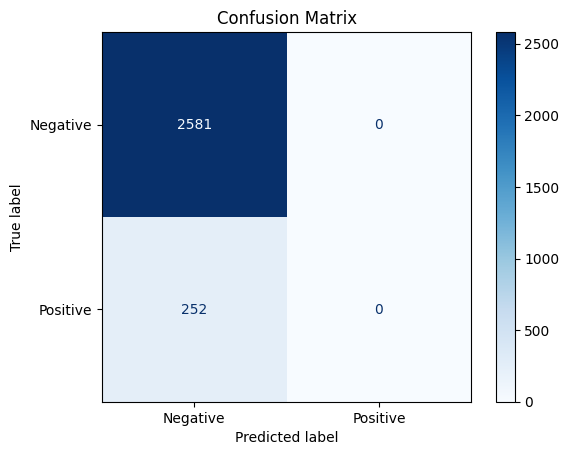

In [52]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/1p_lstm_baseline_cm')

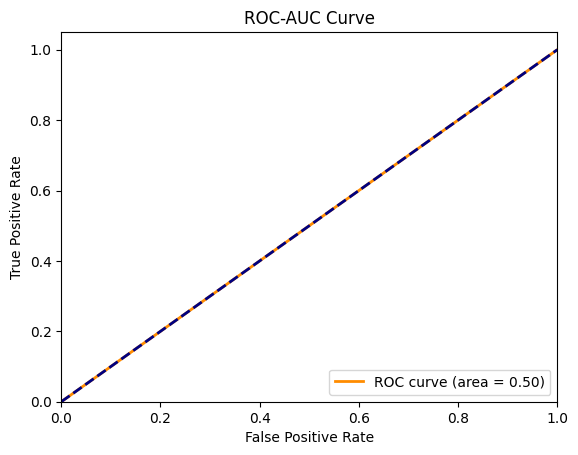

In [53]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/1p_lstm_baseline_roc_auc')

### Transformers

In [42]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=6, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

2024-05-15 18:48:08.571327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 18:48:08.571393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 18:48:08.571420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 18:48:08.685197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 18:48:08.685247: I external/local_xla/xla/stream_executor

In [75]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [44]:
transformer_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 2028)]               0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 2028, 400)            9200      ['Input[0][0]']               
                                                                                                  
 positional_encoding (Posit  (None, 2028, 400)            0         ['Embeddings[0][0]']          
 ionalEncoding)                                                                                   
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 2028, 400)            3847600   ['positional_encoding[0][0

In [45]:
history = transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=5, batch_size=32)

Epoch 1/5


2024-05-15 18:48:11.618542: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa194003510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 18:48:11.618572: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-15 18:48:11.645121: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-15 18:48:11.727561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


  1/354 [..............................] - ETA: 16:03 - loss: 1.5840 - accuracy: 0.0312

I0000 00:00:1715788091.828408   25637 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 [==============================] - 174s 485ms/step - loss: 0.3302 - accuracy: 0.9068
Epoch 2/5
354/354 [==============================] - 172s 486ms/step - loss: 0.3080 - accuracy: 0.9098
Epoch 3/5
354/354 [==============================] - 173s 489ms/step - loss: 0.3084 - accuracy: 0.9098
Epoch 4/5
354/354 [==============================] - 172s 487ms/step - loss: 0.3059 - accuracy: 0.9098
Epoch 5/5
354/354 [==============================] - 173s 488ms/step - loss: 0.3065 - accuracy: 0.9098


In [46]:
predictions = transformer_1.predict(sequences_1p_test)

89/89 [==============================] - 16s 181ms/step


In [47]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.3005


In [48]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



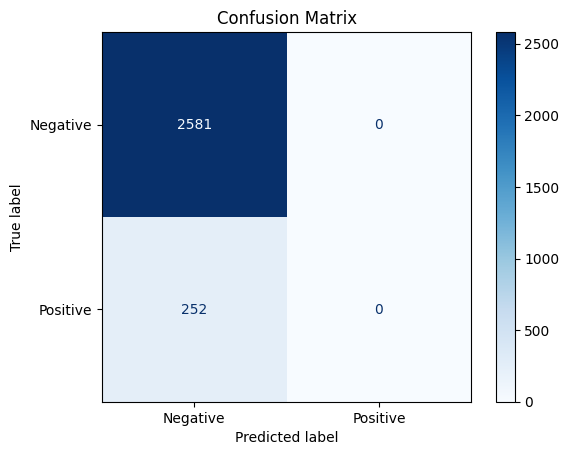

In [49]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/1p_transformer_1_cm')

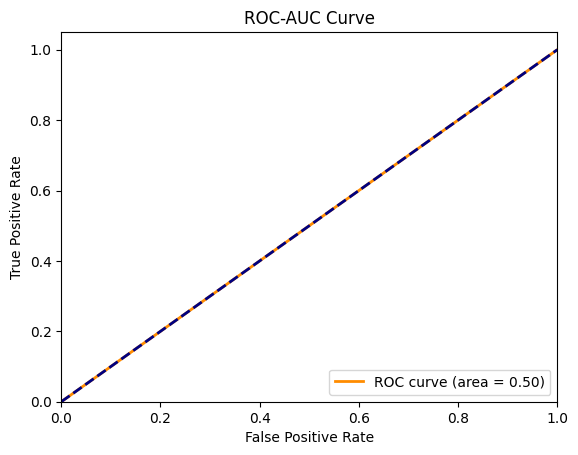

In [50]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/1p_transformer_1_roc_auc')

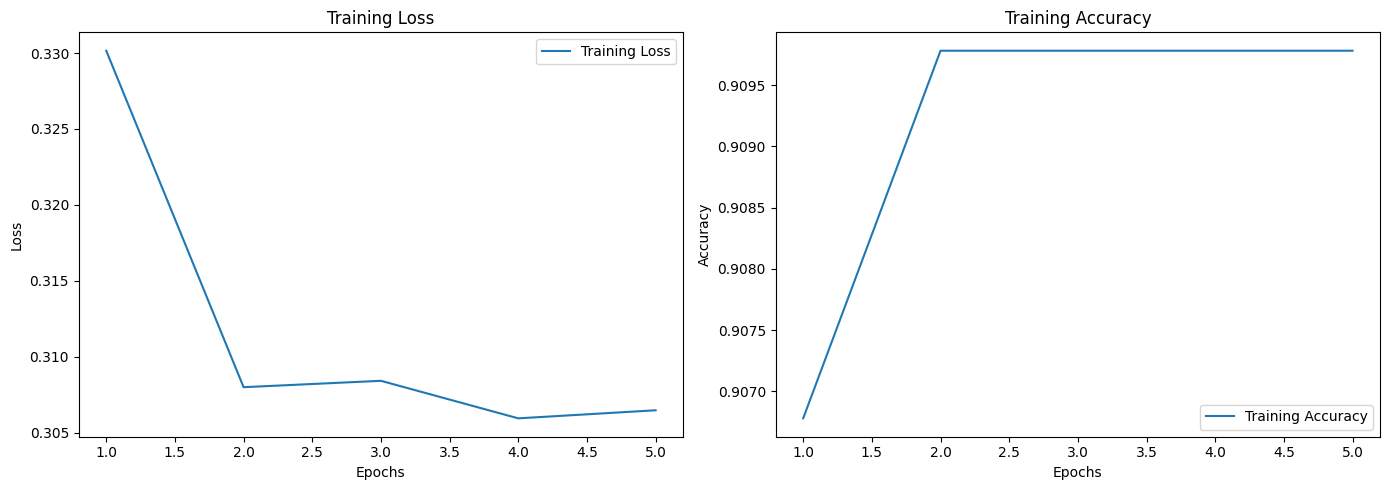

In [51]:
hf.plot_history(history)

## Modeling (2 Aminos Tokenization)

In [52]:
sequence_len = sequences_2p_train.shape[1]
voc_size = len(tokenizer2.word_index)
embedding_dim = 400

### LSTM

In [66]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [67]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1014)]            0         
                                                                 
 Embeddings (Embedding)      (None, 1014, 400)         186400    
                                                                 
 LSTM_layer_1 (LSTM)         (None, 1014, 20)          33680     
                                                                 
 dropout_3 (Dropout)         (None, 1014, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [68]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy'])

In [69]:
history = model_1.fit(sequences_2p_train, labels_2p_train, epochs=2, batch_size=25)

Epoch 1/2
454/454 [==============================] - 46s 98ms/step - loss: 0.0840 - accuracy: 0.9098
Epoch 2/2
454/454 [==============================] - 46s 101ms/step - loss: 0.0826 - accuracy: 0.9098


In [70]:
predictions = model_1.predict(sequences_2p_test)

89/89 [==============================] - 6s 67ms/step


In [71]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.4165


In [72]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



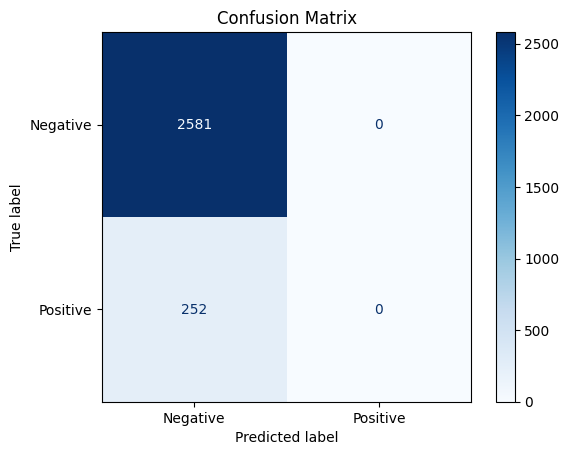

In [73]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_cm')

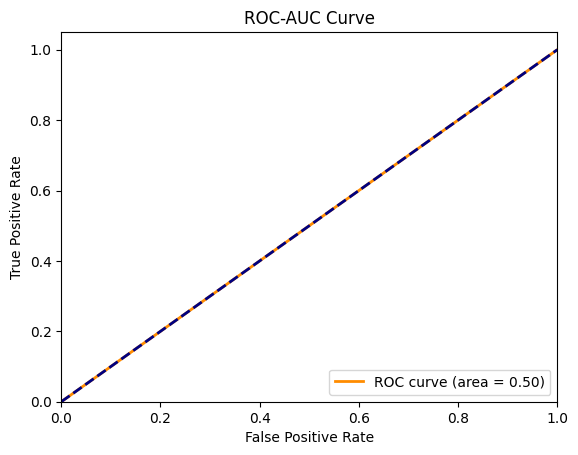

In [74]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_roc_auc')

### Transformers

In [118]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=6, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [119]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [120]:
transformer_1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 1014)]               0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 1014, 400)            186400    ['Input[0][0]']               
                                                                                                  
 positional_encoding_8 (Pos  (None, 1014, 400)            0         ['Embeddings[0][0]']          
 itionalEncoding)                                                                                 
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 1014, 400)            3847600   ['positional_encoding_8[

In [128]:
history = transformer_1.fit(sequences_2p_train, labels_2p_train, epochs=10, batch_size=32)

Epoch 1/10
354/354 [==============================] - 63s 178ms/step - loss: 0.3066 - accuracy: 0.9098
Epoch 2/10
354/354 [==============================] - 63s 179ms/step - loss: 0.3054 - accuracy: 0.9098
Epoch 3/10
354/354 [==============================] - 64s 179ms/step - loss: 0.3048 - accuracy: 0.9098
Epoch 4/10
354/354 [==============================] - 63s 179ms/step - loss: 0.3046 - accuracy: 0.9098
Epoch 5/10
354/354 [==============================] - 63s 179ms/step - loss: 0.3045 - accuracy: 0.9098
Epoch 6/10
354/354 [==============================] - 64s 180ms/step - loss: 0.3036 - accuracy: 0.9098
Epoch 7/10
354/354 [==============================] - 64s 180ms/step - loss: 0.2973 - accuracy: 0.9097
Epoch 8/10
354/354 [==============================] - 63s 179ms/step - loss: 0.2936 - accuracy: 0.9098
Epoch 9/10
354/354 [==============================] - 63s 179ms/step - loss: 0.2910 - accuracy: 0.9093
Epoch 10/10
354/354 [==============================] - 64s 180ms/step - l

In [129]:
predictions = transformer_1.predict(sequences_2p_test)

89/89 [==============================] - 6s 66ms/step


In [130]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.9114013413342746
Loss:  0.2927


In [131]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.53      0.04      0.07       252

    accuracy                           0.91      2833
   macro avg       0.72      0.52      0.51      2833
weighted avg       0.88      0.91      0.87      2833



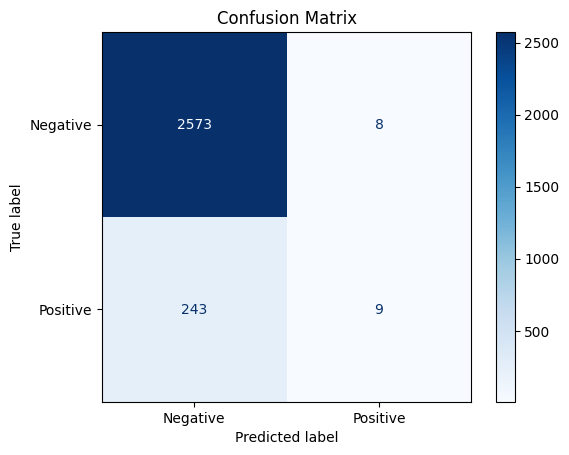

In [132]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_transformer_1_cm')

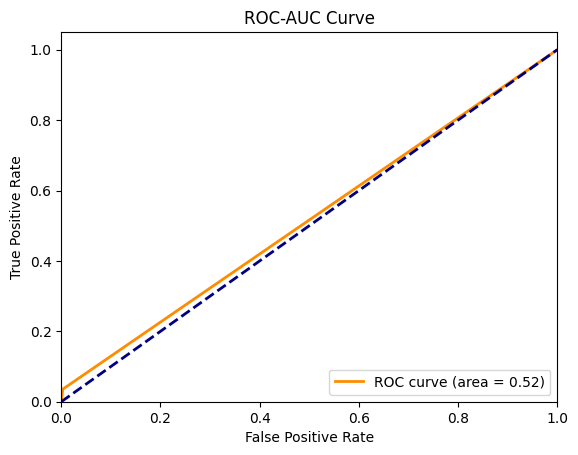

In [133]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_transformer_1_roc_auc')

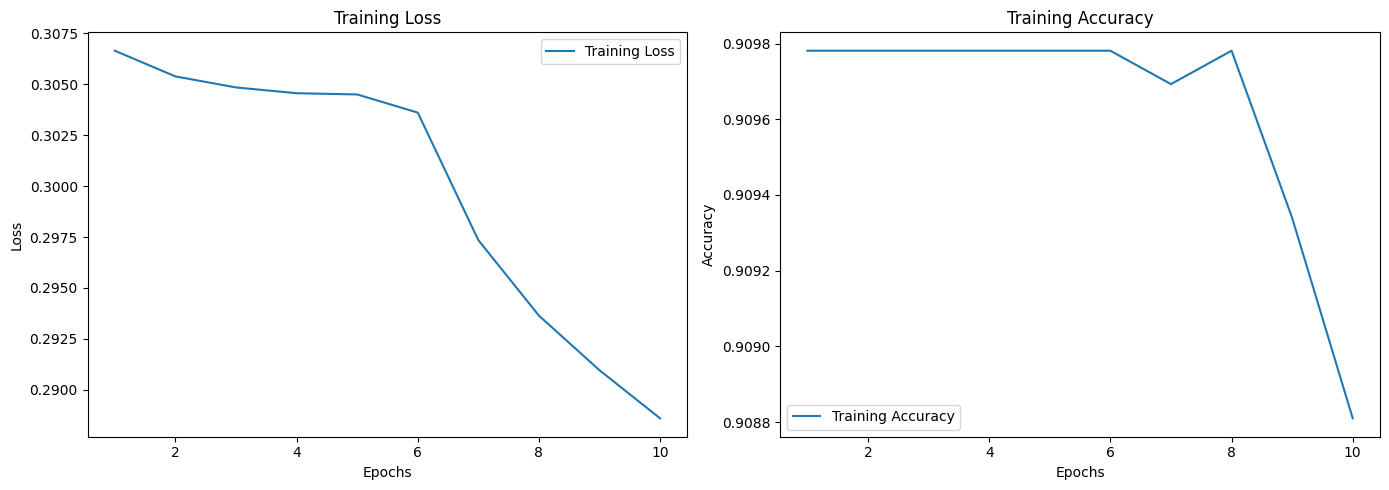

In [134]:
hf.plot_history(history)